In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import daft
from google.colab.patches import cv2_imshow
import cv2

We will analyze full version of this dataset by using `BMI` ($BMI$), `children_count` ($CC$), `age` ($AGE$), `smoke` ($SM$),`region` ($RG$),  `sex` ($SX$), and `price` ($PC$) from this dataset. 

In [30]:
pgm = daft.PGM()
pgm.add_node("SM","SM",0,4)
pgm.add_node("SX","SX",0,2)
pgm.add_node("BMI","BMI",4,4)
pgm.add_node("AGE","AGE",2,2)
pgm.add_node("CC","CC",2,3)
pgm.add_node("RG","RG",4,1)
pgm.add_node("PC","PC",2,0)
pgm.add_edge("CC", "AGE")
pgm.add_edge("BMI", "CC")
pgm.add_edge("AGE", "PC")
pgm.add_edge("AGE", "RG")
pgm.add_edge("AGE", "SX")
pgm.add_edge("SM", "SX")
pgm.add_edge("CC","SM")
pgm.add_edge("SM", "PC")
pgm.add_edge("SX", "PC")
pgm.add_edge("RG", "PC")
pgm.add_edge("BMI","RG")
pgm.add_edge("BMI", "PC")
pgm.add_edge("BMI","SM")
pgm.render()
pgm.savefig("health-insurance-dag.jpg")

TypeError: ignored

The above daft PGM does not work in google colab, so I took a snip of the DAG and printed it below. But on a regular jupyter notebook one can safely use it.

In [4]:
img = cv2.imread('/content/health-insurance-dag.jpg')

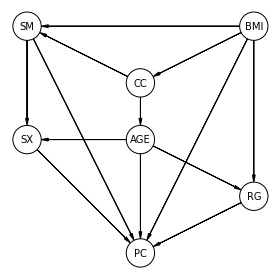

In [5]:
cv2_imshow(img)

In our project, we are discussing whether gender and/or region have significant effect on the pricing of the health insurances. To be able to analyze this fully, one must analyze both first as individuals in a causal system, later on continue with a third step and adjust one of the $region$ or $sex$ to have a last idea on the case.

1) Here for to analyze the causal total and direct effect of the gender on the prices to analyze the gender effect, we should stratify the $age$ and $smoke$ parameters of people, but $smoker$ parameter should be coded to have a clear model.

2) We will measure the effect of the region total and direct again with similar method, but this time $BMI$ and $age$ should be stratified to have a better understanding of the effect.

3) As last part we will consider both parameters and that being said for the one that is adjusted we should add that parameter to the model to see full predictive model, and analyze the results.

In [6]:
df = pd.read_csv('/content/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Part A

Here we will stratify the hierarchical model for all of the given parameters for both $smoker$ and $age$.

In [7]:
df["SM"] = pd.Categorical(df["smoker"]).codes

In [8]:
df["sx"] = pd.Categorical(df["sex"]).codes

In [9]:
df["ag"] = pd.Categorical(df["age"]).codes # age is not actually categorical, but can be thought as
# a cluster for each age.

# by that we can also visualize that effect too.

In [10]:
df.head()

,age,sex,bmi,children,smoker,region,charges,SM,sx,ag
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,1
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,10
3,33,male,22.705,0,no,northwest,21984.47061,0,1,15
4,32,male,28.880,0,no,northwest,3866.85520,0,1,14


Females are coded as 0, males are coded as 1. 
Smokers are coded as 1, non_smokers are coded as 0.

In [11]:
df_A = df # to make each part easier for the user to understand.

In [12]:
pd.unique(df_A["ag"])

array([ 1,  0, 10, 15, 14, 13, 28, 19, 42,  7, 44,  5, 38,  9, 34, 12, 16,
       41, 45, 37,  4,  8, 17,  6, 23, 20, 18,  3, 30, 22, 40, 35, 25, 46,
        2, 43, 26, 39, 11, 27, 36, 31, 29, 33, 24, 32, 21], dtype=int8)

In [13]:
len(pd.unique(df_A["age"]))

47

The centered model with stratify intercept:
$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]} + \beta_{S[i]} + \beta_{A[i]}
\\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) \qquad \text{for} \ j \in 1..2 
\\
\beta_s &\sim \text{Normal}(0, 0.1) \qquad \text{for} \ a \in 1..2 
\\
\beta_a &\sim \text{Normal}(0, 0.01) \qquad \text{for} \ k \in 1..47 
\\
\bar{\alpha} &\sim \text{Normal}(0, 0.01)
\\
\sigma_{\alpha} &\sim \text{Exponential}(0.01)
\\
\sigma &\sim \text{Uniform}(0, 10)    
\end{align*}
$$

In [14]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series 

# thanks to Alaz hocam I could solve the model issue.

In [15]:
df_A["charges_std"] = standardize(df_A["charges"]) # to make the derivates non-zero.

In [16]:
with pm.Model() as mA:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    a_bar = pm.Normal("a_bar", 0, 0.01)
    sigma_A = pm.Exponential("sigma_A", 0.01)

    alpha_A = pm.Normal("alpha_A", mu=a_bar, sigma=sigma_A, shape=2)
    beta_S = pm.Normal("beta_S", mu=0, sigma=0.1, shape=2)
    beta_A = pm.Normal("beta_A", mu=0, sigma=0.01, shape=47)
    
    mu = alpha_A[df_A.sx.values-1] + beta_S[df_A.SM.values] + beta_A[df_A.ag.values]

    g = pm.Normal("G", mu=mu, sigma=sigma, observed=df_A.charges_std)
    
    trace_A = pm.sample(1000, tune = 1000, target_accept=0.95, init="adapt_diag", return_inferencedata = True )
az.summary(trace_A)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_A, beta_S, alpha_A, sigma_A, a_bar, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,0.000,0.011,-0.020,0.019,0.000,0.000,5412.0,1476.0,1.00
alpha_A[0],0.521,0.074,0.369,0.648,0.002,0.001,1422.0,1523.0,1.00
alpha_A[1],0.517,0.076,0.379,0.663,0.002,0.001,1439.0,1428.0,1.00
beta_S[0],-0.886,0.073,-1.028,-0.759,0.002,0.001,1451.0,1301.0,1.00
beta_S[1],0.905,0.074,0.771,1.046,0.002,0.001,1280.0,1216.0,1.00
beta_A[0],-0.008,0.010,-0.028,0.010,0.000,0.000,4244.0,1258.0,1.00
beta_A[1],-0.007,0.009,-0.023,0.011,0.000,0.000,4853.0,1413.0,1.01
beta_A[2],-0.004,0.010,-0.022,0.014,0.000,0.000,5603.0,1504.0,1.00
beta_A[3],-0.003,0.010,-0.023,0.013,0.000,0.000,4740.0,1397.0,1.00
beta_A[4],-0.002,0.010,-0.021,0.016,0.000,0.000,6390.0,1400.0,1.00


index 0 for beta_S is female and index 1 is male as coded.

Here from the results it is interesting to see that to the  female human having higher price rates for the health insurances, but relatively slightly with 0.004 mean difference, but we see that for male and female prices tend to increase regardless of gender. So gender has low effect on the increase of price, but female being on the negative side of the decrease of price trend comparably to males.

Furthermore, we see that after certain age, again higher index numbers at beta_A scores are increasing with age. so index 46 is actually the eldest person. To come back to main topic, we can say that after certain age which here is the index 25, something around 40-50 years old starts to change the trend for a health insurance company to change their pricing. After index 25 the prices start to have an increasing trend also due to age.

We also have the smoker parameter that is shown with beta_S that indicates that smoking highly effects the pricing of the health insurances. Beta_S=1 shows us that smokers tend to pay higher approx 0.9 mean when compared to Beta_S = 0 the mean of increase is -0.886.

In [53]:
trace_A.keys() # to understand what are the keys to plot them.

KeysView(Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data)

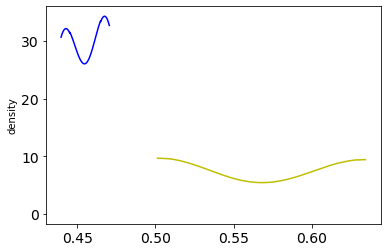

In [57]:
_, ax = plt.subplots(1, 1, figsize=(6, 4))
az.plot_dist(trace_A.posterior["alpha_A"][:,0], ax=ax, color='y')
az.plot_dist(trace_A.posterior["alpha_A"][:,1], ax=ax, color='b')
ax.set_ylabel("density");

Here we will see gender differences both on posterior plot and trace, on the effect of pricing.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8423841d0>,
      dtype=object)

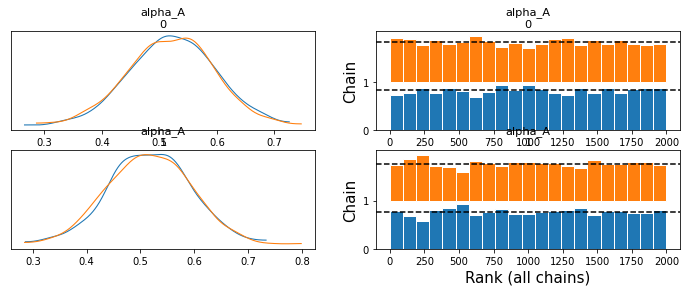

In [58]:
az.plot_trace(trace_A, kind = "rank_bars", var_names=["alpha_A"], compact = False)

Here we will see effect of age on the pricing stratified at the gender based pricing analysis.

/usr/local/lib/python3.7/dist-packages/arviz/plots/traceplot.py:216: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (47), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc86101e710>,
      dtype=object)

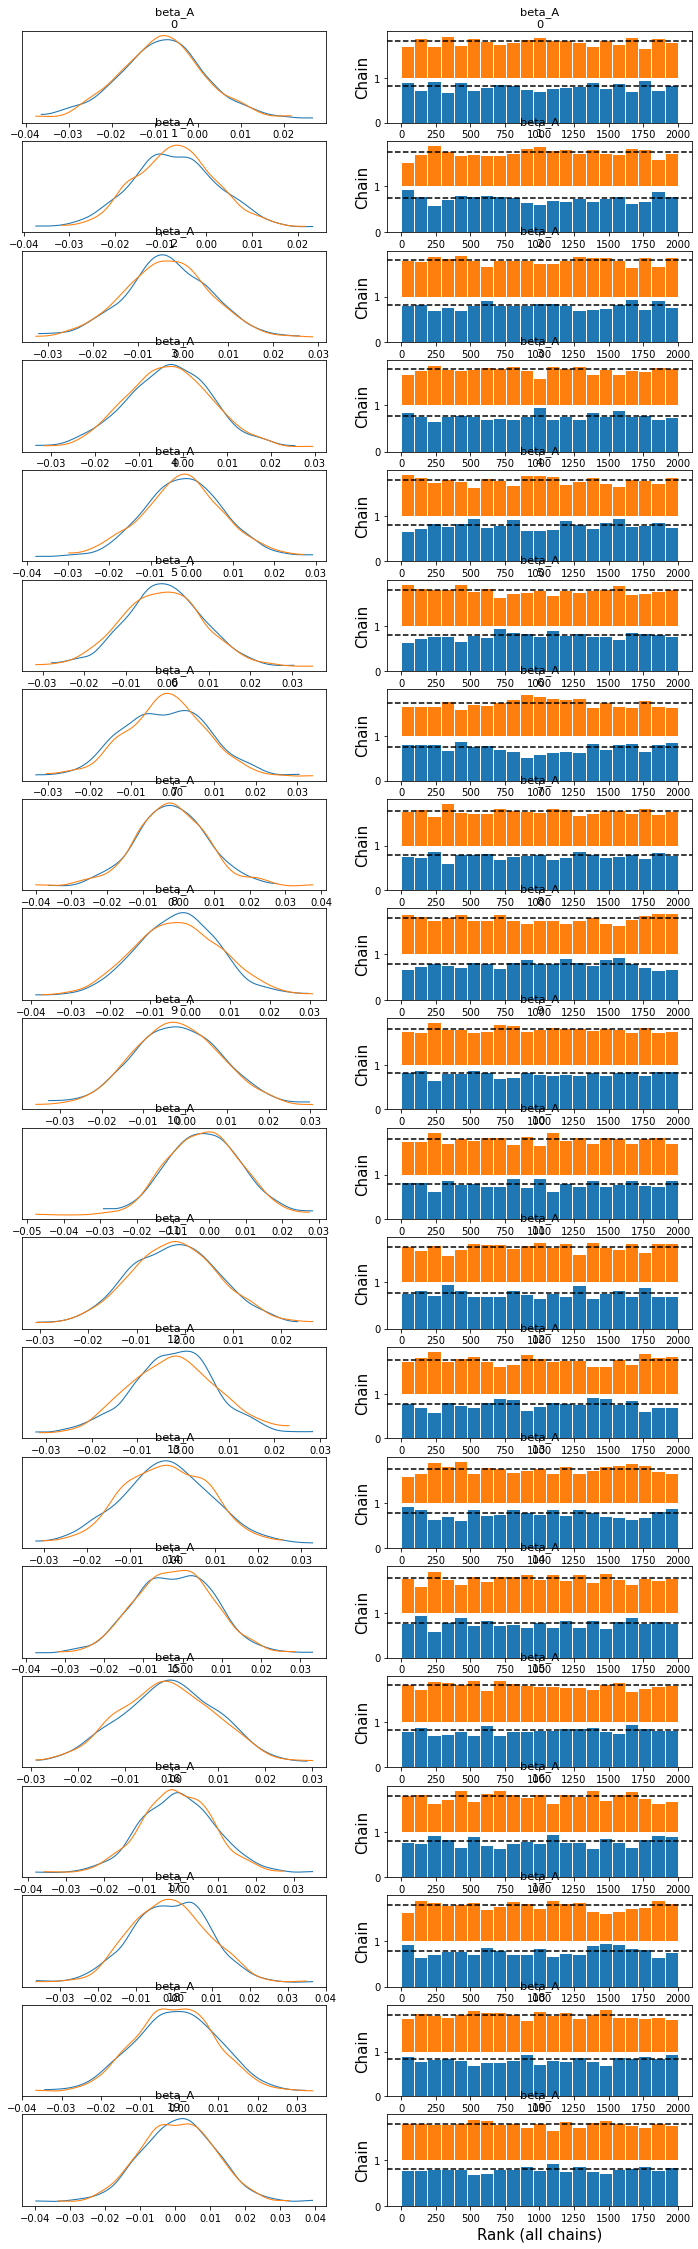

In [59]:
az.plot_trace(trace_A, kind = "rank_bars", var_names=["beta_A"], compact = False)

Lastly, we will review smoker parameter $Beta_S$ for to see the effects.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8585a4bd0>,
      dtype=object)

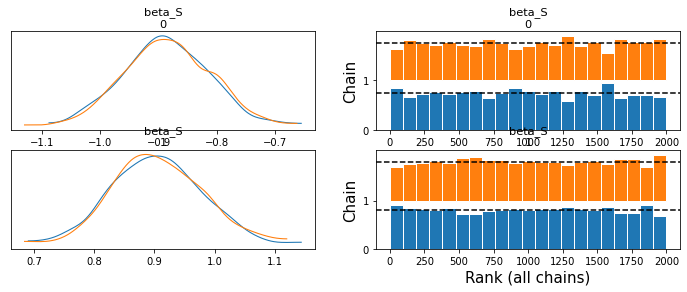

In [60]:
az.plot_trace(trace_A, kind = "rank_bars", var_names=["beta_S"], compact = False)

1) On the gender trace plot and the density plot we see slight inclination of the female gender to higher pricing. Moreover, we can clearly see from the values on the smoker parameters that smokers may not be seen inclined to increasing price trend however, when looked at the means below them it is evident that smoking skyrockets the health insurance prices.

2) We also see that $Age$ in a system with $smoker$ and $gender$ does not have that much of a statistically significant increasing effect on the prices.

# Part B

Here we will stratify the hierarchical model for all of the given parameters both for $bmi$ and $age$.

In [21]:
df["rg"] = pd.Categorical(df["region"]).codes

In [22]:
df.head()

,age,sex,bmi,children,smoker,region,charges,SM,sx,ag,charges_std,rg
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,1,0.298472,3
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0,-0.953333,2
2,28,male,33.000,3,no,southeast,4449.46200,0,1,10,-0.728402,2
3,33,male,22.705,0,no,northwest,21984.47061,0,1,15,0.719574,1
4,32,male,28.880,0,no,northwest,3866.85520,0,1,14,-0.776512,1


In [23]:
df_B = df # to make each part easier for the user to understand.

In [24]:
df_B["charges_std"] = standardize(df_B["charges"])
df_B["bmi_std"] = pd.Categorical(round(df_B["bmi"])).codes # think bmi as cluster
# fatter people will have different charges and can be thought as denser tanks.

In [25]:
len(pd.unique(df_B.bmi_std))

36

In [27]:
with pm.Model() as mB:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    rg_bar = pm.Normal("rg_bar", 0, 0.1)
    sigma_rg = pm.Exponential("sigma_rg", 0.1)

    alpha_rg = pm.Normal("alpha_rg", mu=rg_bar, sigma=sigma_rg, shape=4)
    beta_bmi = pm.Normal("beta_bmi", mu=0, sigma=0.1, shape = 36)
    beta_A = pm.Normal("beta_A", mu=0, sigma=0.1, shape=47)
    
    mu = alpha_rg[df_B.rg.values] + beta_bmi[df_B.bmi_std.values] + beta_A[df_A.ag.values]

    g = pm.Normal("G", mu=mu, sigma=sigma, observed=df_B.charges_std)
    
    trace_B = pm.sample(1000, tune = 1000, target_accept=0.95, init="adapt_diag", return_inferencedata = True )
az.summary(trace_B)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_A, beta_bmi, alpha_rg, sigma_rg, rg_bar, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rg_bar,0.012,0.055,-0.087,0.121,0.001,0.001,1404.0,1265.0,1.0
alpha_rg[0],0.037,0.053,-0.071,0.129,0.001,0.001,1275.0,1399.0,1.0
alpha_rg[1],-0.028,0.057,-0.133,0.071,0.002,0.001,1418.0,1570.0,1.0
alpha_rg[2],0.093,0.056,-0.007,0.197,0.002,0.001,964.0,1189.0,1.0
alpha_rg[3],-0.038,0.057,-0.146,0.065,0.002,0.001,929.0,1314.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_A[44],0.090,0.093,-0.091,0.249,0.002,0.002,1934.0,1356.0,1.0
beta_A[45],0.101,0.090,-0.061,0.277,0.002,0.002,2763.0,937.0,1.0
beta_A[46],0.150,0.088,-0.027,0.311,0.002,0.001,2758.0,1451.0,1.0
sigma,0.964,0.019,0.928,1.002,0.000,0.000,1810.0,1105.0,1.0


Here we see that for people who have higher BMI, indexes that are higher indicates higher BMI scores show that when people get fat price of the health insurance tend to increase but slightly, however since for the lower BMI it tends to lower the score, we can state that higher BMI has an effect when it combined with the region.

Specific regions have negative effect on the price decrease such as the $'Southeast'$ region has slightly higher prices, may be it is due to $'Southeast'$ being an industrial zone.

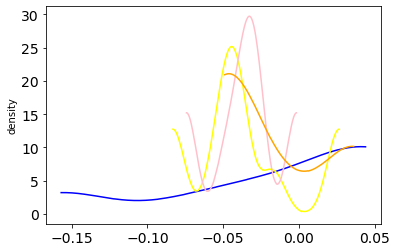

In [56]:
_, ax = plt.subplots(1, 1, figsize=(6, 4))
az.plot_dist(trace_B.posterior["alpha_rg"][:,0], ax=ax, color='b')
az.plot_dist(trace_B.posterior["alpha_rg"][:,1], ax=ax, color='yellow')
az.plot_dist(trace_B.posterior["alpha_rg"][:,2], ax=ax, color='pink')
az.plot_dist(trace_B.posterior["alpha_rg"][:,3], ax=ax, color='orange')
ax.set_ylabel("density");

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc841471bd0>,
      dtype=object)

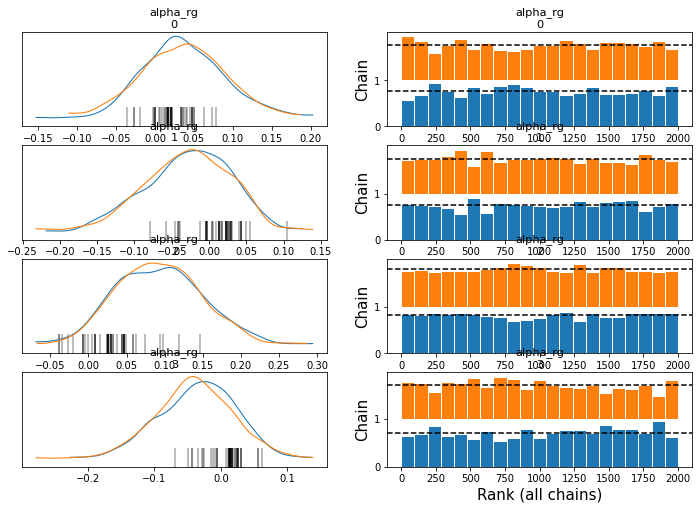

In [61]:
az.plot_trace(trace_B, kind = "rank_bars", var_names=["alpha_rg"], compact = False)

/usr/local/lib/python3.7/dist-packages/arviz/plots/traceplot.py:216: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (36), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc841475610>,
      dtype=object)

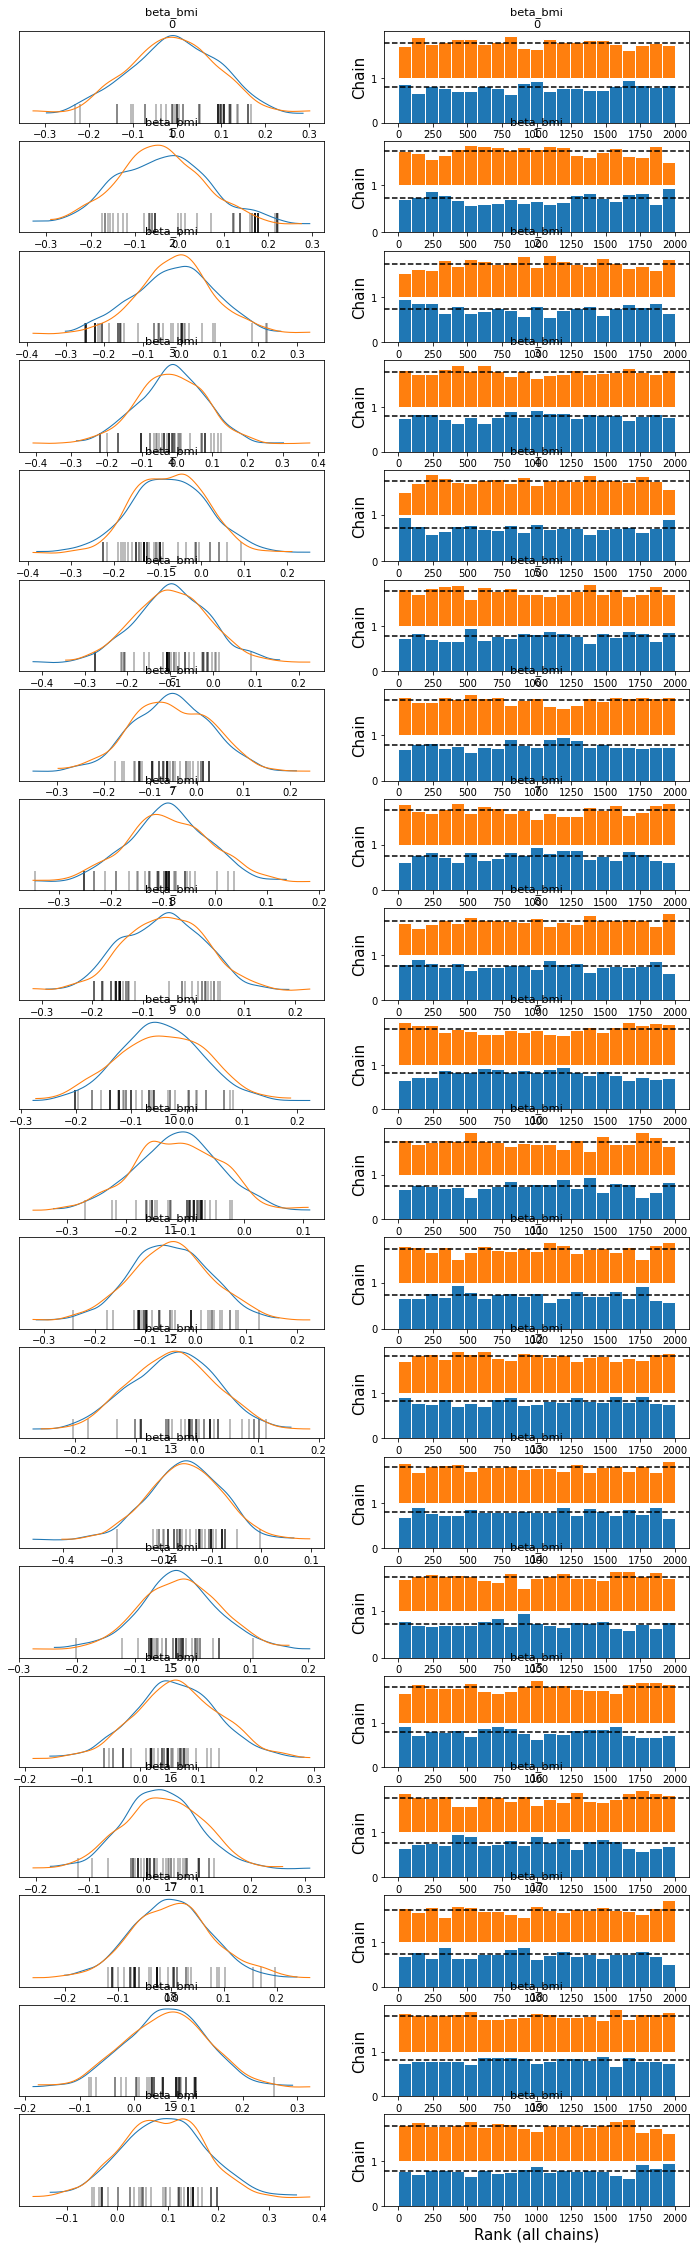

In [62]:
az.plot_trace(trace_B, kind = "rank_bars", var_names=["beta_bmi"], compact = False)

BMI based results in the region effect shows us that BMI increases the variance of the price, but does not contribute significantly on the increase or decrease of the pricing of health insurances.


/usr/local/lib/python3.7/dist-packages/arviz/plots/traceplot.py:216: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (47), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc83fa02c10>,
      dtype=object)

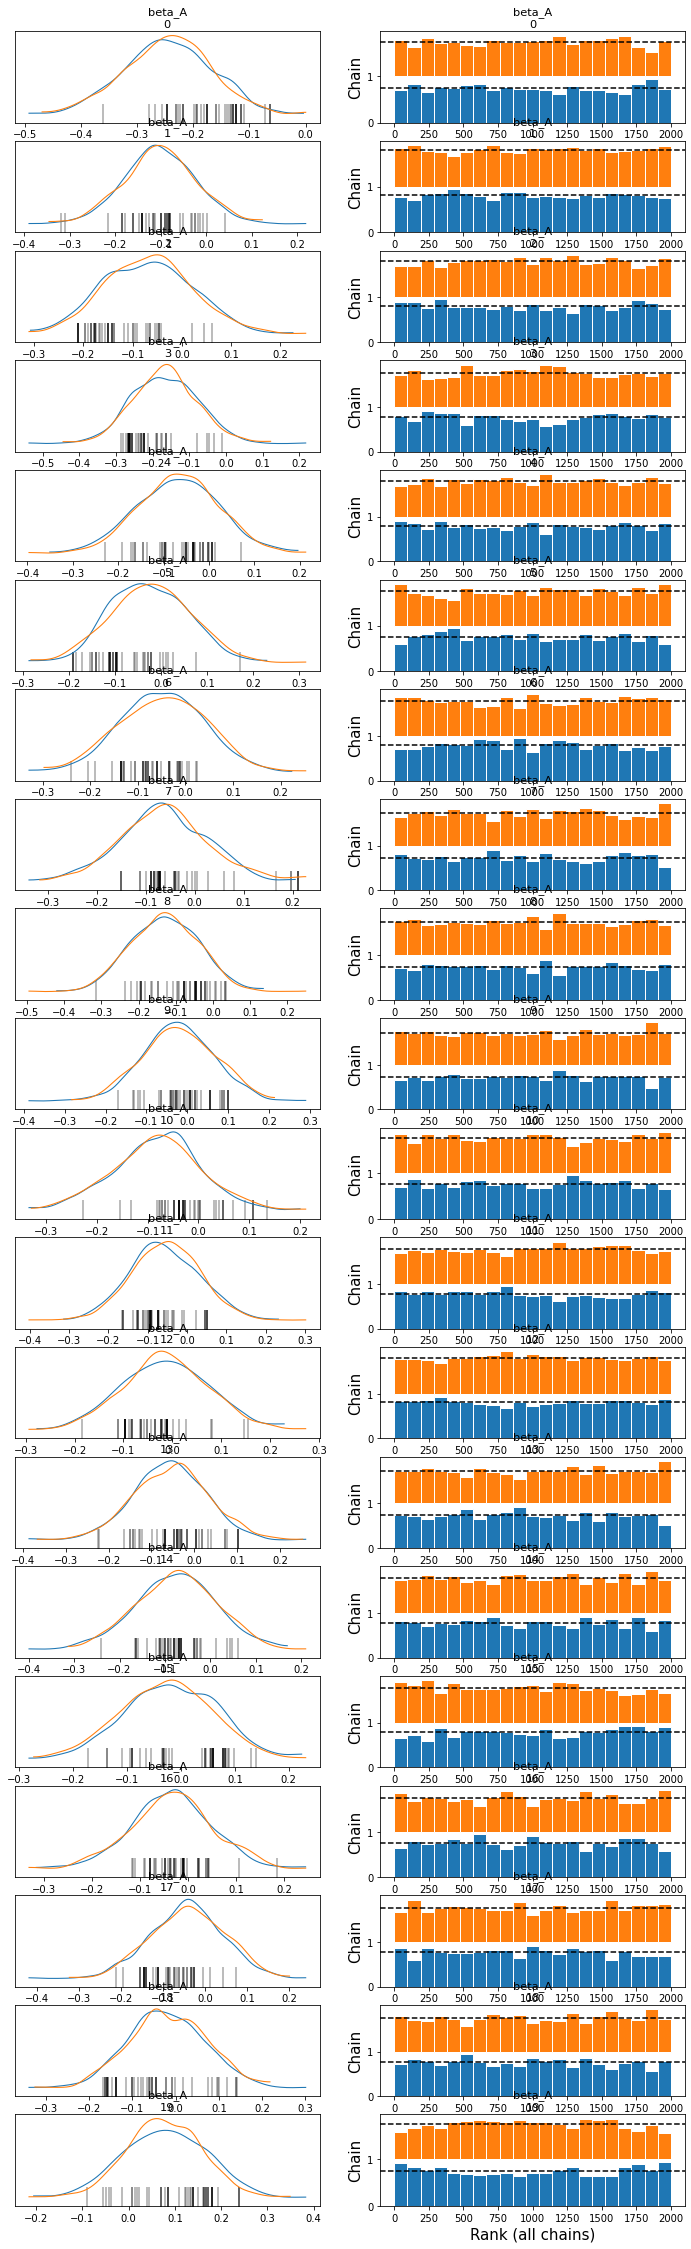

In [63]:
az.plot_trace(trace_B, kind = "rank_bars", var_names=["beta_A"], compact = False)

1) Here we see for the age parameter with $region$ considered model, we can say that young people tend to pay less due to decreasing price trend for young $age$ for the model.

2) We can also say that BMI increases the variability and $region$ certainly changes the pricing.

# Part C

Here we will stratify the hierarchical model for all of the given parameters below $sex$, $bmi$, and $age$.

To allocate memory and make the model, we reduced the observation size randomly without replace.

Also we want to expect to use a somewhat multivariate model to analyze the full system and later on compare the performances of $part A$, $part B$, $part C$, which will show us, which parameter contributes to the charges the most.

In [32]:
df_C = df.sample(frac=0.05, replace = False)

In [33]:
df_C.index = np.arange(1, len(df_C)+1)

In [34]:
df_C["bmi_stand"] = standardize(df_C["bmi_std"])

In [35]:
df_C

,age,sex,bmi,children,smoker,region,charges,SM,sx,ag,charges_std,rg,bmi_std,bmi_stand
1,30,male,37.430,3,no,northeast,5428.72770,0,1,12,-0.647538,0,21,1.105337
2,57,female,23.180,0,no,northwest,11830.60720,0,0,39,-0.118895,1,7,-1.608815
3,26,male,33.915,1,no,northwest,3292.52985,0,1,8,-0.823938,1,18,0.523733
4,54,male,31.600,0,no,southwest,9850.43200,0,1,36,-0.282410,3,16,0.135997
5,54,male,30.020,0,no,northwest,24476.47851,0,1,36,0.925355,1,14,-0.251739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,58,male,32.010,1,no,southeast,11946.62590,0,1,40,-0.109314,2,16,0.135997
64,43,male,27.800,0,yes,southwest,37829.72420,1,1,25,2.028016,3,12,-0.639475
65,56,male,31.790,2,yes,southeast,43813.86610,1,1,38,2.522165,2,16,0.135997
66,43,male,20.130,2,yes,southeast,18767.73770,1,1,25,0.453948,2,4,-2.190418


Hierarchical multivariate model with sex and region combined with adjustment and exposure:

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \bar{\alpha}_{rg[i]} +  \alpha_{A[i],S[i],BM[i]}
\\
\alpha &= (\text{diag}(\boldsymbol{S}_A) \boldsymbol{L}_A \boldsymbol{Z}_{T,A})^{T}
\\
\boldsymbol{Z}_{T,rg,A,S,BMI} &\sim \text{Normal}(0, 1) \qquad \text{for}
\ i,j,k \in  1..36, 1..30, 1..47
\\
\text{z}_{\bar{A},j} &\sim \text{Normal}(0, 1) \qquad \text{for} \ j \in 1..4
\\
\bar{\alpha} &= \text{z}_{\bar{A},j} \tau_A
\\
\boldsymbol{S}_{A}, \tau_A &\sim \text{Exponential}(1)
\\
\boldsymbol{R}_A &\sim \text{LKJcorr}(30,4)    
\end{align*}
$$

In [44]:
with pm.Model() as mC:
    sigma_dist = pm.Exponential.dist(1.0)
    chol_actor, _, _= pm.LKJCholeskyCov("chol_actor", n = 30, eta = 4, sd_dist = sigma_dist, compute_corr = True)
    tau_A = pm.Exponential('tau_A', 1)
    z_A = pm.Normal("z_A", 0, 1, shape = 4)
    a_bar = z_A * tau_A
    z_actor = pm.Normal("z_actor", 0, 1, shape = (36,30,47))
    a = pm.math.dot(chol_actor, z_actor).T
    mu = a_bar[df_C.rg.values-1] + a[df_C.ag.values-1, df_C.sx.values-1,df_C.bmi_std.values-1]
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    g = pm.Normal("G", mu=mu, sigma=sigma, observed=df_C.charges_std)
    trace_C = pm.sample(1000, tune = 1000, target_accept=0.95, init="adapt_diag", return_inferencedata = True )
    
az.summary(trace_C)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, z_actor, z_A, tau_A, chol_actor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15366 seconds.
The acceptance probability does not match the target. It is 0.8463083879843815, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929775723595805, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z_A[0],-0.711,0.687,-2.137,0.542,0.047,0.033,201.0,619.0,1.01
z_A[1],0.907,0.714,-0.327,2.385,0.029,0.021,609.0,540.0,1.00
z_A[2],-0.291,0.701,-1.552,1.137,0.069,0.049,99.0,944.0,1.02
z_A[3],-0.301,0.664,-1.597,0.977,0.032,0.023,438.0,888.0,1.01
"z_actor[0, 0, 0]",0.059,0.994,-1.785,1.948,0.021,0.030,2136.0,1033.0,1.01
...,...,...,...,...,...,...,...,...,...
"chol_actor_corr[29, 27]",0.007,0.167,-0.305,0.323,0.005,0.003,1347.0,1186.0,1.00
"chol_actor_corr[29, 28]",-0.004,0.162,-0.314,0.291,0.004,0.003,1543.0,1561.0,1.00
"chol_actor_corr[29, 29]",1.000,0.000,1.000,1.000,0.000,0.000,1906.0,1940.0,1.00
tau_A,0.431,0.296,0.001,0.946,0.022,0.016,161.0,439.0,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc83e6b4790>,
      dtype=object)

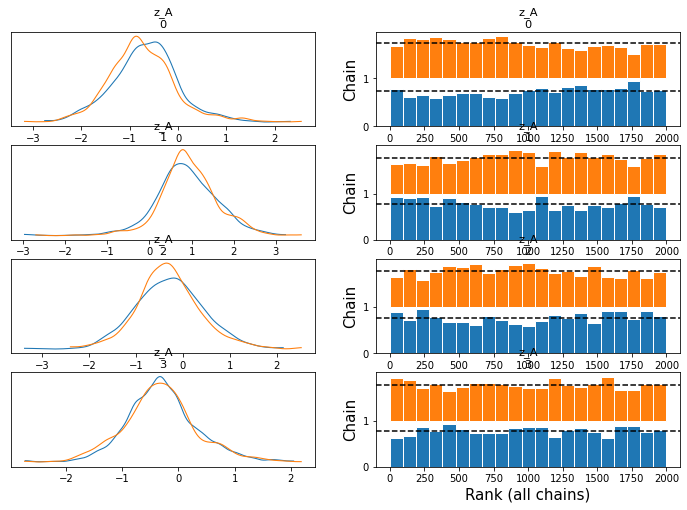

In [64]:
az.plot_trace(trace_C, kind = "rank_bars", var_names=["z_A"], compact = False)

Shows that second region has a tendency to have higher pricing for health insurance by the reasons only can be thought of such as industry, dirty air and so. z_A_1 directly shows that.

As from the summary above for Part_C which indicates a multivariate structure for $region$ effect when $sex$, $bmi$, and $age$ variables are stratified, which means included to be able to see the direct effect of the $region$, when other parameters observed and exposed are imposed to the model. 

1) From the page one with the 4 indexes of z_A we see that second region with index one has a positive effect on the pricing for the insurance companies, and that can be due to the site being an industrial zone or rich neighborhood, etc. 

2) from the z_actor parameter that is dependent on the age, gender, bmi and region shows us that for changing age, gender and bmi, there are no big changes in the pricing compared with the regional change.

3) By comparison of the three parts analyzed, we can state that $regional effect$ is critical on pricing health insurances. However, contrary to the belief of women have much more pricey health insurances are not seen that visible by the models created. This does not mean gender based pricing is negligible, however it indicates that for the data set used and for the prior model designed, it is seen that difference in pricing for different genders are not as much as statistically significant as $Region$ or $Smoker$.

4) Gender is indeed an important parameter on pricing, but not as much as smoking or region based on the dataset used and models created by the prior belief.

# Extra Part C

Here we will look at the chol_actor_corr parameter plot.

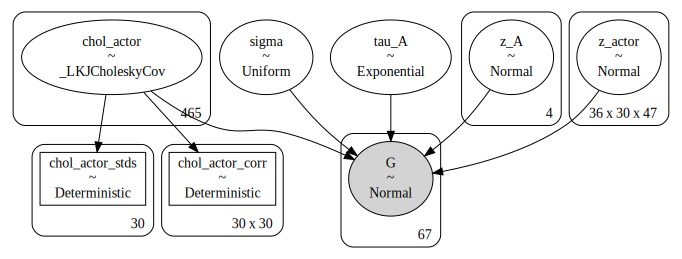

In [66]:
from graphviz import Digraph
pm.model_to_graphviz(mC)

In [69]:
az.summary(trace_C.posterior.chol_actor_corr)

/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"chol_actor_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,2000.0,2000.0,NaN
"chol_actor_corr[0, 1]",0.002,0.167,-0.312,0.325,0.005,0.004,1147.0,1039.0,1.0
"chol_actor_corr[0, 2]",0.001,0.166,-0.294,0.315,0.005,0.004,1184.0,815.0,1.0
"chol_actor_corr[0, 3]",0.004,0.173,-0.330,0.316,0.007,0.005,684.0,753.0,1.0
"chol_actor_corr[0, 4]",0.003,0.173,-0.308,0.325,0.005,0.004,1209.0,1206.0,1.0
...,...,...,...,...,...,...,...,...,...
"chol_actor_corr[29, 25]",-0.004,0.160,-0.290,0.294,0.005,0.004,1064.0,1356.0,1.0
"chol_actor_corr[29, 26]",-0.007,0.167,-0.316,0.297,0.004,0.003,1413.0,1217.0,1.0
"chol_actor_corr[29, 27]",0.007,0.167,-0.305,0.323,0.005,0.003,1347.0,1186.0,1.0
"chol_actor_corr[29, 28]",-0.004,0.162,-0.314,0.291,0.004,0.003,1543.0,1561.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/plots/traceplot.py:216: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (900), generating only 20 plots
  UserWarning,
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc83d7d0910>,
      dtype=object)

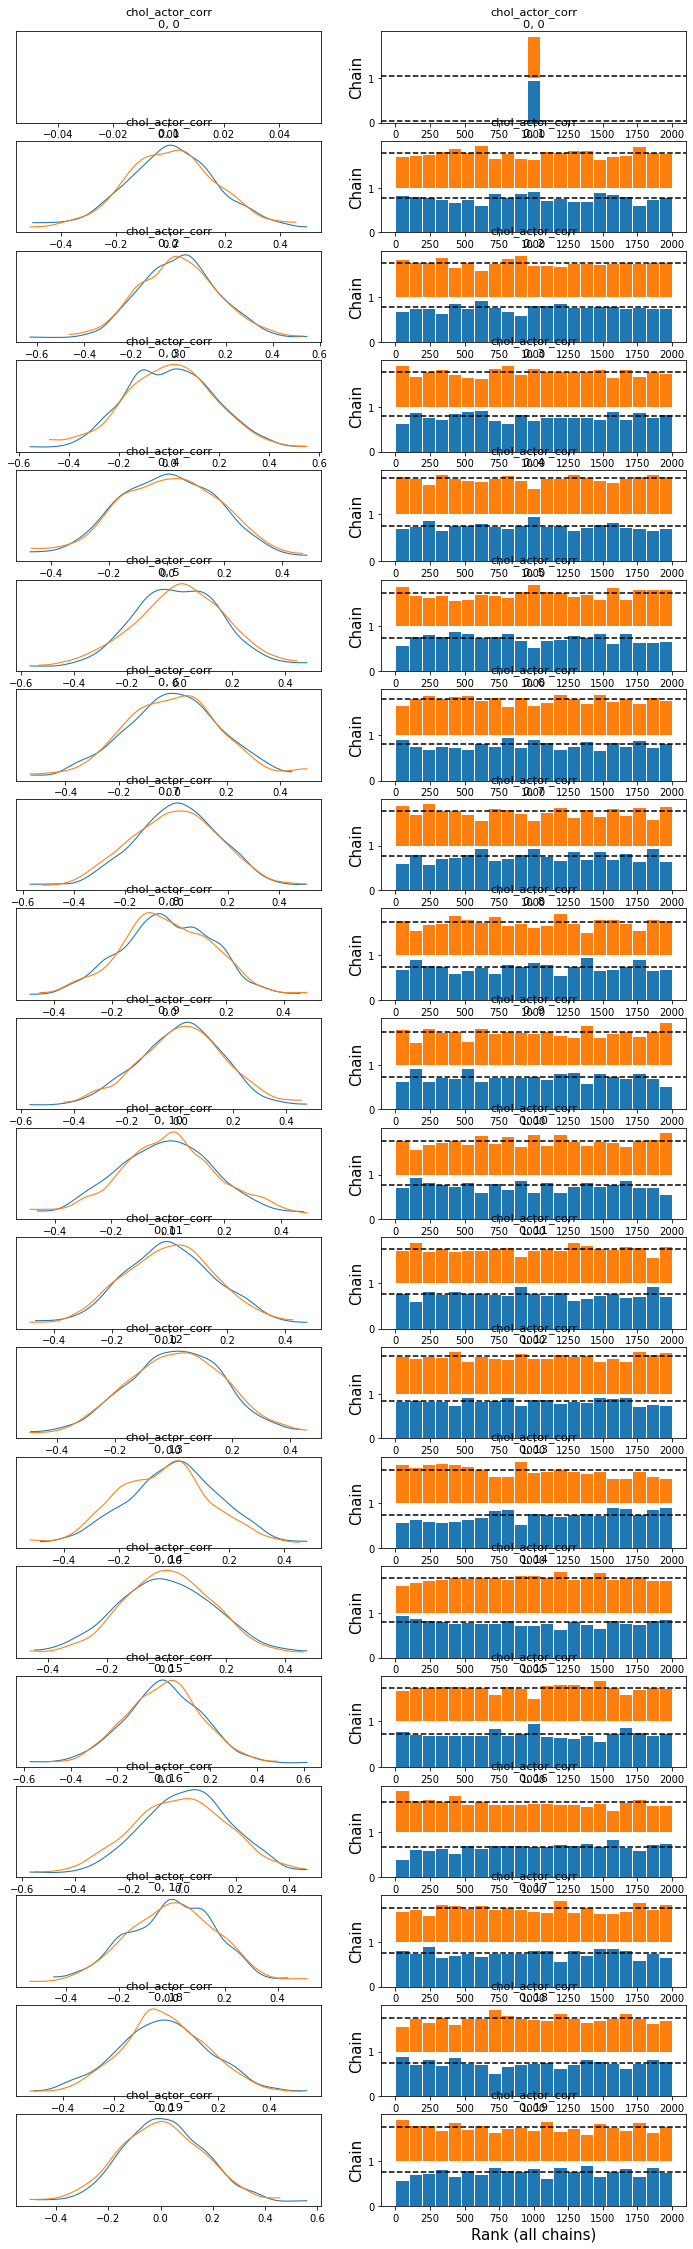

In [65]:
az.plot_trace(trace_C, kind = "rank_bars", var_names=["chol_actor_corr"], compact = False)

Here from the chol_actor_correlation we see that for the equal indexed cholesky covariance matrix correlations show significant underlying correlations are formed and put into the model.